This notebook produces figures of the cleaned variable coverage in three options:
- Single variable figure
- 1+ variable options, handling for odd/even number of variables passed
- All variables in a single figure

In [1]:
# Import libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from io import BytesIO, StringIO
from datetime import datetime, timezone, date
import geopandas as gpd
import contextily as cx

import matplotlib.colors as colors

In [2]:
# Read in our specific pre-set per network colormap

# to get colors from existing colormaps
# [colors.to_hex(rgba) for rgba in plt.get_cmap('tab20b')(np.arange(20))]

# combination of tab20c_r + tab20b colormaps
color_dict = {}
with open('network_colors.txt') as f:
    for line in f:
        (key, val) = line.split()
        color_dict[key] = str("#") + str(val)
        
color_dict

{'ASOSAWOS': '#d9d9d9',
 'CAHYDRO': '#bdbdbd',
 'CDEC': '#969696',
 'CIMIS': '#636363',
 'CNRFC': '#dadaeb',
 'CRN': '#bcbddc',
 'CW3E': '#9e9ac8',
 'CWOP': '#756bb1',
 'HADS': '#c7e9c0',
 'HNXWFO': '#a1d99b',
 'HOLFUY': '#74c476',
 'HPWREN': '#31a354',
 'LOXWFO': '#fdd0a2',
 'MAP': '#fdae6b',
 'MARITIME': '#fd8d3c',
 'MTRWFO': '#e6550d',
 'NCAWOS': '#c6dbef',
 'NDBC': '#9ecae1',
 'NOS-NWLON': '#6baed6',
 'NOS-PORTS': '#3182bd',
 'OtherISD': '#de9ed6',
 'RAWS': '#ce6dbd',
 'SCAN': '#a55194',
 'SGXWFO': '#7b4173',
 'SHASAVAL': '#e7969c',
 'SNOTEL': '#d6616b',
 'VCAPCD': '#ad494a'}

In [3]:
def var_fullname(var):
    """Returns the full name of variable for title purposes"""
    if var == "tas":
        var_title = "Air temperature ({})".format(var)
    if "tdps" in var:
        var_title = "Dewpoint temperature ({})".format(var)
    elif var == "hurs":
        var_title = "Relative humidity ({})".format(var)
    elif var == "rsds":
        var_title = "Radiation ({})".format(var)
    elif var == "sfcwind":
        var_title = "Surface wind speed ({})".format(var)
    elif var == "sfcwind_dir":
        var_title = "Surface wind direction ({})".format(var)
    elif "pr" in var:
        var_title = "Precipitation ({})".format(var)
    elif "ps" in var and "td" not in var:
        var_title = "Air pressure ({})".format(var)
    
    return var_title

In [4]:
def gdf_setup(var):
    # AWS set-up
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    bucket_name = "wecc-historical-wx"
    
    # Read in all stations
    obj = s3_cl.get_object(Bucket=bucket_name, Key="2_clean_wx/temp_clean_all_station_list.csv")
    body = obj['Body'].read()
    df_all = pd.read_csv(BytesIO(body), encoding='utf8')
    
    # ------------------------------------------------------------------------------------------------------------
    # Make a geodataframe
    gdf = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.longitude, df_all.latitude))
    gdf.set_crs(epsg=4326, inplace=True) # Set CRS

    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

    # Read in geometry of WECC
    mar = gpd.read_file("s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp")
    ter = gpd.read_file("s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp")
    wecc = gpd.GeoDataFrame(pd.concat([mar, ter]))
    
    # Use to clip stations
    wecc = wecc.to_crs(epsg = 3857)
    gdf_wecc = gdf_wm.clip(wecc)
    gdf_wecc = gdf_wecc.sort_values(['network'])

    # Setting color
    gdf_wecc['Color'] = gdf_wecc['network'].map(color_dict)

    # Subsetting based on variable
    new_gdf = gdf_wecc.loc[gdf_wecc[str(var)+'_nobs'] > 0]
    
    return new_gdf

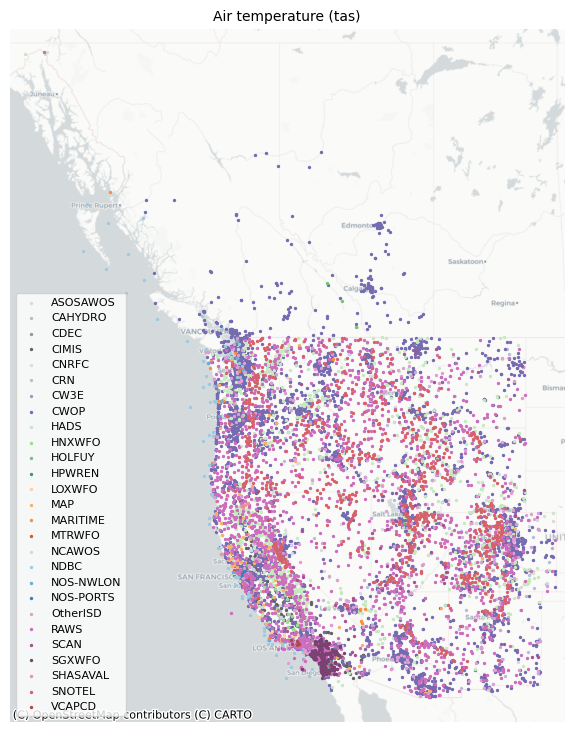

<Figure size 640x480 with 0 Axes>

In [5]:
# Run function - generate station map
def single_var_map(var):
    
    # aws set-up
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    bucket_name = "wecc-historical-wx"
    
    # grab gdf per variable
    gdf = gdf_setup(var)
        
    # figure global settings
    fig, ax = plt.subplots(figsize=(9,9))
    a=1 # alpha
    ms=2 # markersize
    
    # enforce WECC boundary, all plots regardless of variable selection
    ylim = [3.5E6, 8.5E6] # lat
    xlim = [-1.53E7, -1.13E7] # lon
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
        
    # plot by network with correct legend color
    for ctype, data in gdf.groupby('network'):
        color = color_dict[ctype]
        data.plot(color=color,
                  markersize=ms, 
                  alpha=a,
                  ax=ax, 
                  label=ctype)
    
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron);

    # legend
    l = ax.legend(loc='lower left', prop={'size':8}, frameon=True)
#     for i in range(len(l.legend_handles)):
#         l.legend_handles[i]._sizes = [20] # sets size of points in legend to be more visible

    # set title
    vartitle = var_fullname(var)
    ax.set_title(vartitle, fontsize=10)
    ax.set_axis_off()
    
    # in notebook, show figure
    plt.show()
    
    # save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)

    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_{}.png".format(var))
    
# Run function to produce plots
single_var_map(var='tas')

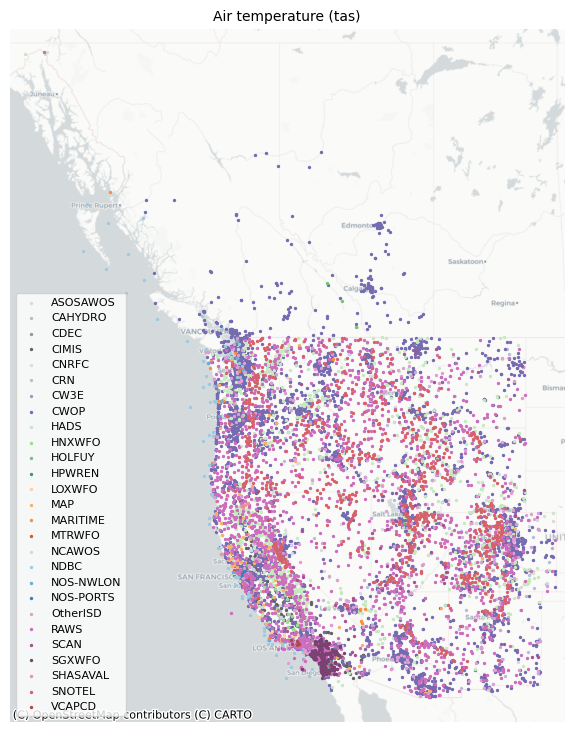

<Figure size 640x480 with 0 Axes>

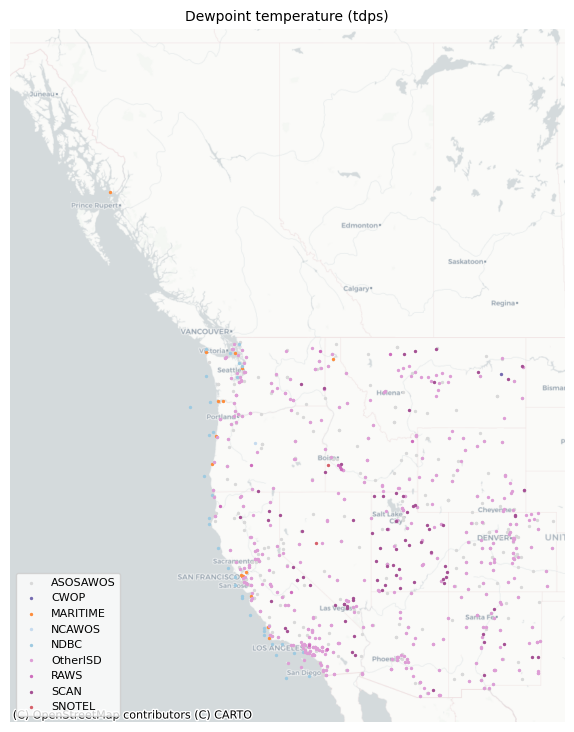

<Figure size 640x480 with 0 Axes>

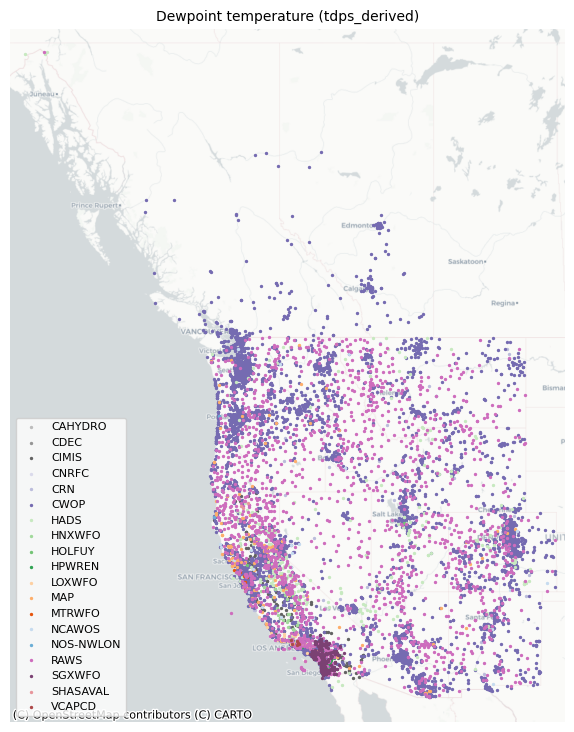

<Figure size 640x480 with 0 Axes>

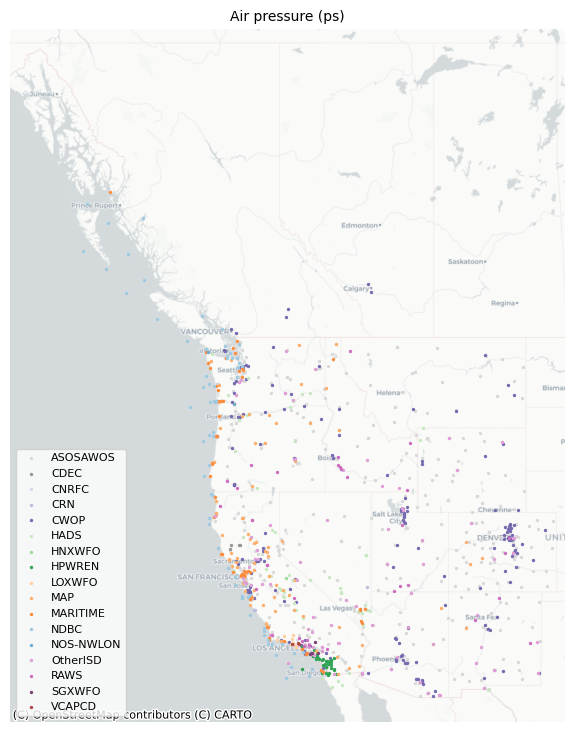

<Figure size 640x480 with 0 Axes>

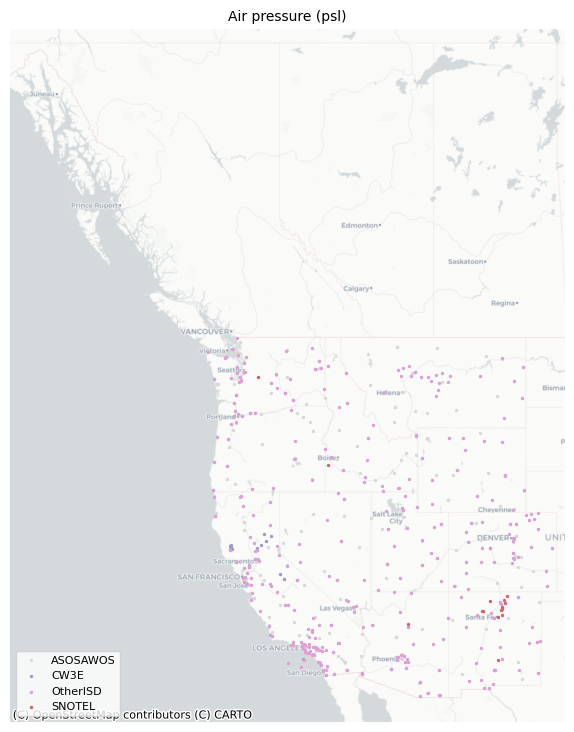

<Figure size 640x480 with 0 Axes>

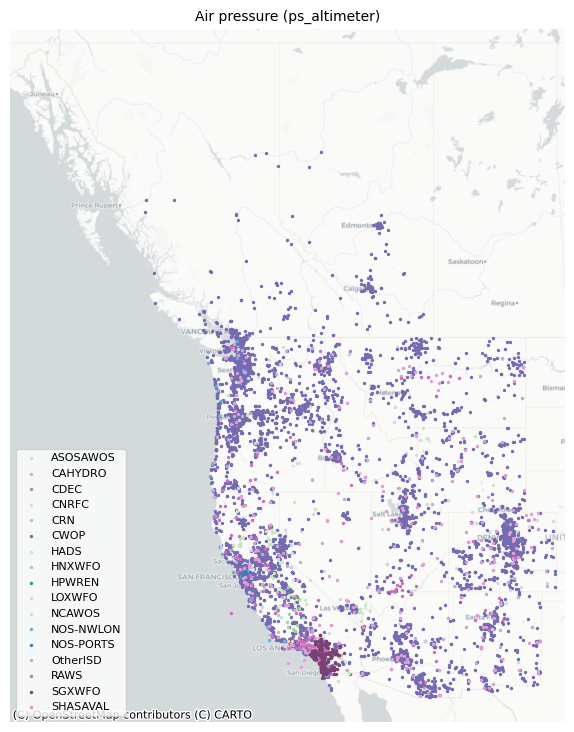

<Figure size 640x480 with 0 Axes>

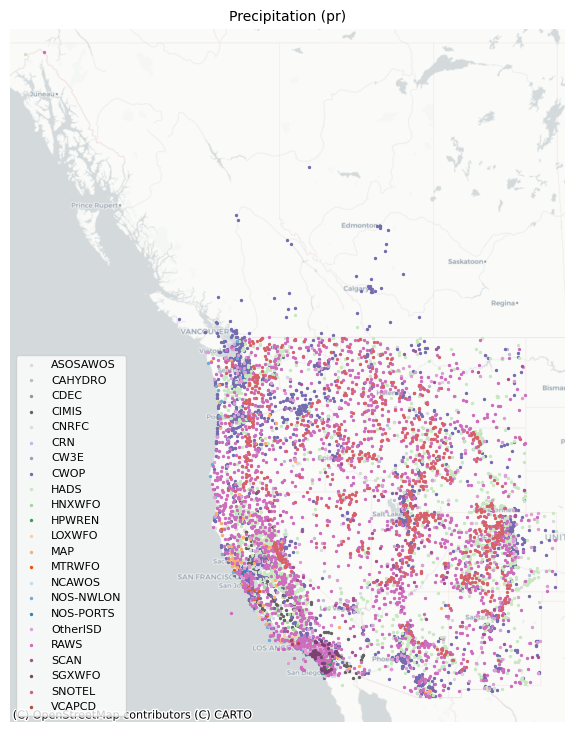

<Figure size 640x480 with 0 Axes>

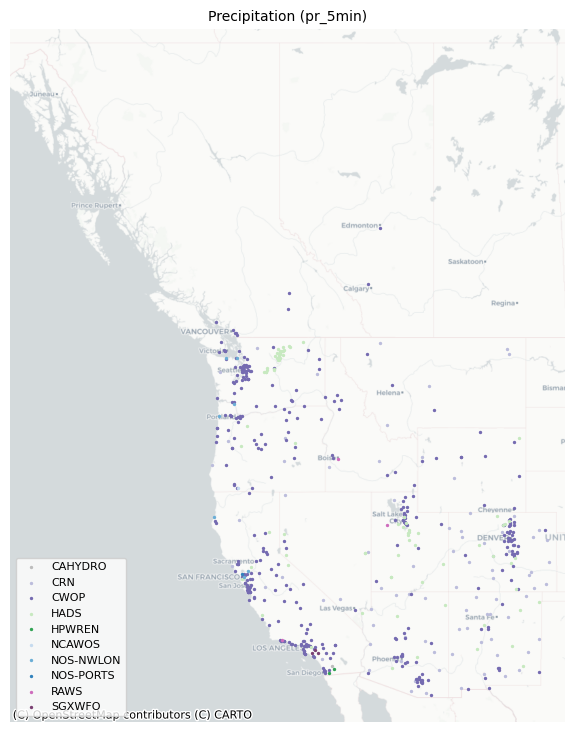

<Figure size 640x480 with 0 Axes>

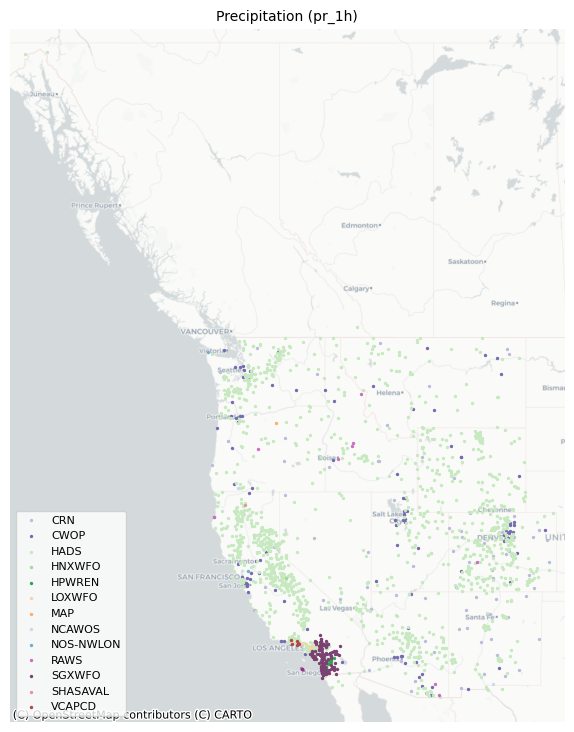

<Figure size 640x480 with 0 Axes>

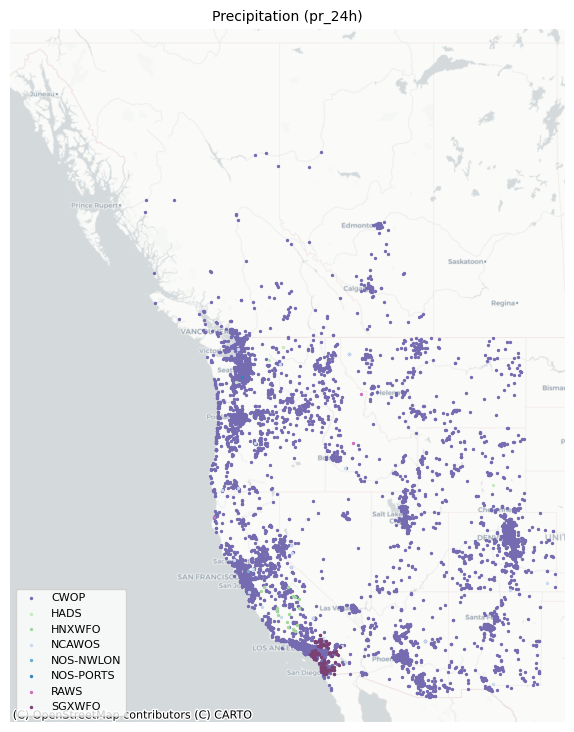

<Figure size 640x480 with 0 Axes>

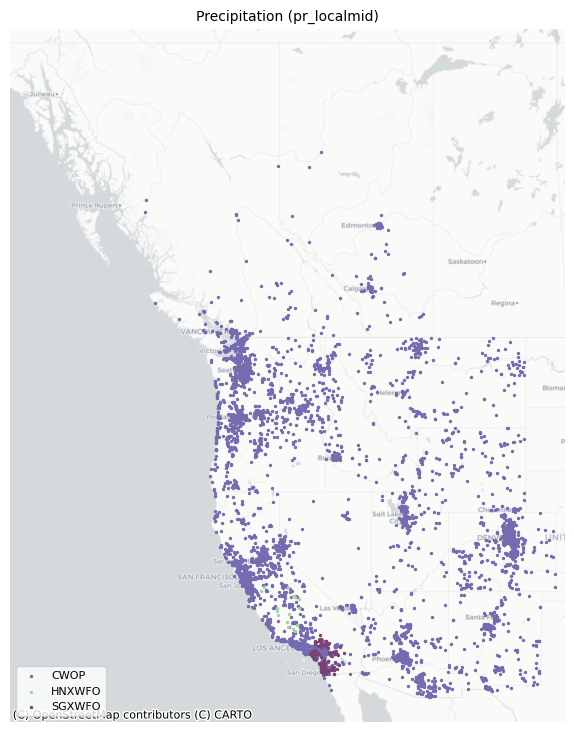

<Figure size 640x480 with 0 Axes>

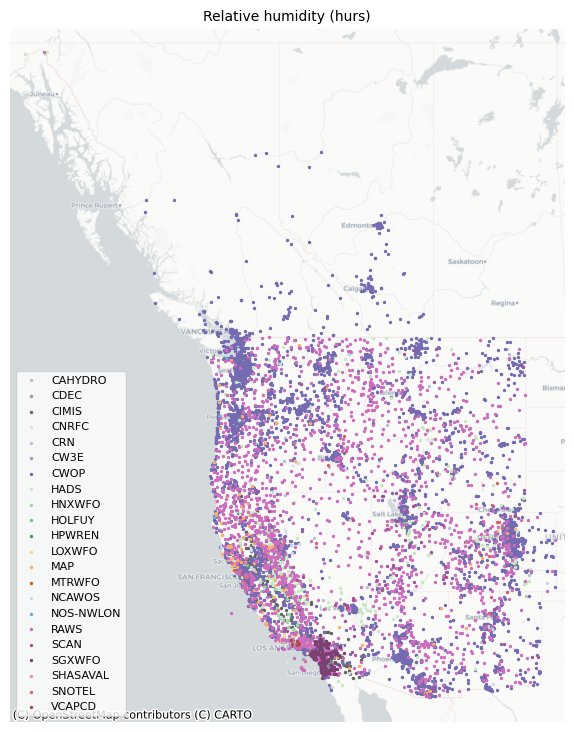

<Figure size 640x480 with 0 Axes>

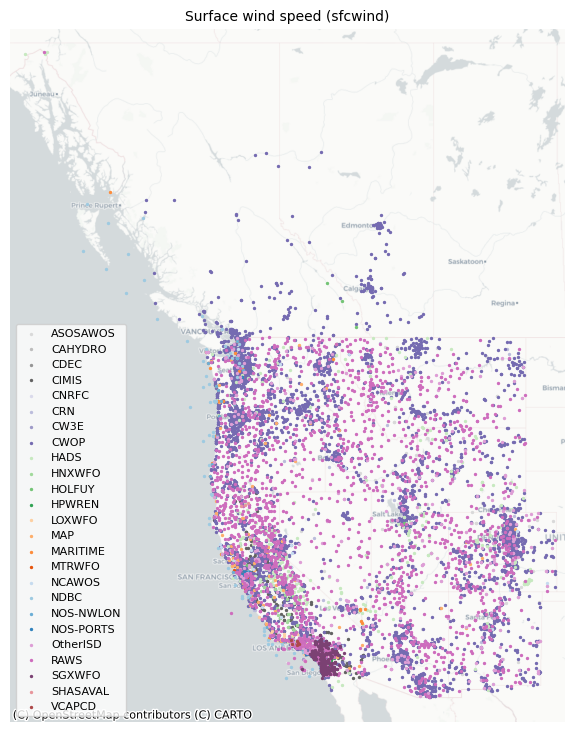

<Figure size 640x480 with 0 Axes>

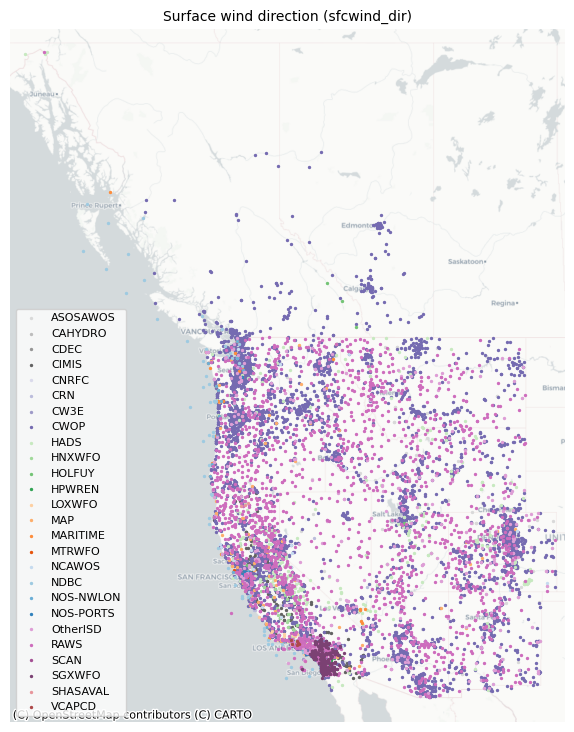

<Figure size 640x480 with 0 Axes>

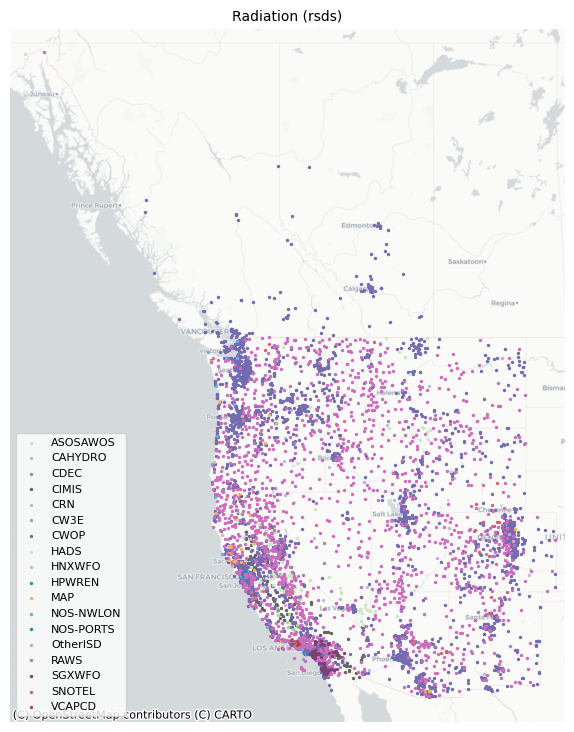

<Figure size 640x480 with 0 Axes>

In [6]:
# generate single maps for all variables
varlist = ['tas','tdps','tdps_derived', 
           'ps','psl','ps_altimeter', 
           'pr','pr_5min','pr_1h','pr_24h','pr_localmid',
           'hurs','sfcwind','sfcwind_dir','rsds']

for var in varlist:
    single_var_map(var=var)

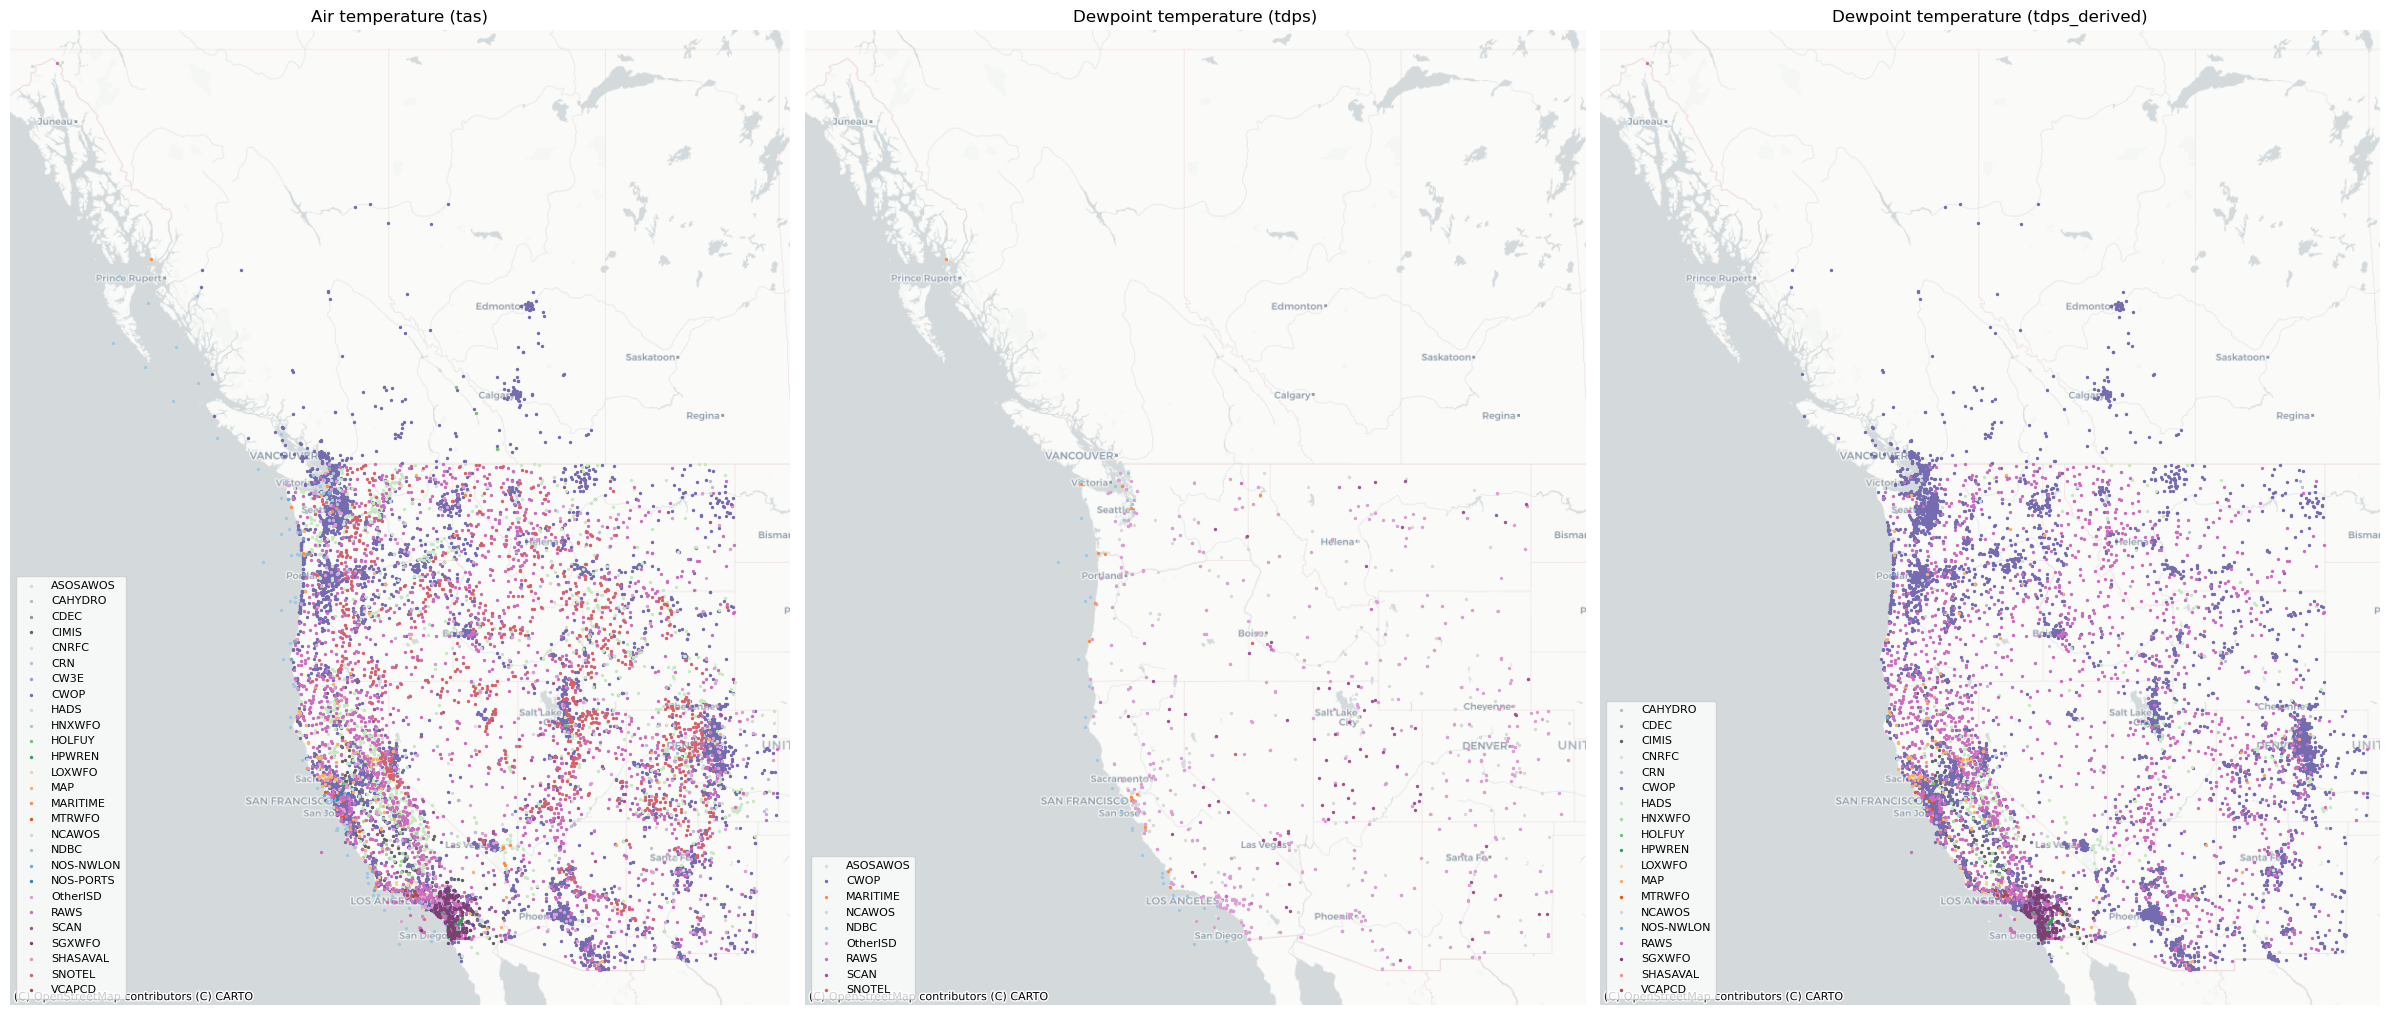

In [7]:
def combo_var_map(multi_var):
    
    # aws set up 
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    bucket_name = "wecc-historical-wx"
          
    # figure global settings
    a=1 # alpha
    ms=2 # markersize
    n=1
    
    # set up - determine how many vars are passed
    if len(multi_var) == 1: # single var passed
        single_var_map(multi_var[0])

        
    elif len(multi_var)%2 == 0: # even number passed
        fig = plt.subplots(nrows=int((len(multi_var)/2)), ncols=2, figsize=(16,20))
        
        for var_to_plot in multi_var:
            ax = plt.subplot((len(multi_var)/2), 2, n)
            
            # enforce WECC boundary, all plots regardless of variable selection
            ylim = [3.5E6, 8.5E6] # lat
            xlim = [-1.53E7, -1.13E7] # lon
            ax.set_ylim(ylim)
            ax.set_xlim(xlim)
            
            gdf = gdf_setup(var_to_plot)
            
            # plot by network with correct legend color
            for ctype, data in gdf.groupby('network'):
                color = color_dict[ctype]
                data.plot(color=color,
                          markersize=ms, 
                          alpha=a,
                          ax=ax, 
                          label=ctype)

            cx.add_basemap(ax, source=cx.providers.CartoDB.Positron);

            # set title
            vartitle = var_fullname(var_to_plot)
            ax.set_title(vartitle, fontsize=12)
            ax.set_axis_off()
            
            # legend
            l = ax.legend(loc='lower left', prop={'size':8}, frameon=True)
#             for i in range(len(l.legend_handles)):
#                 l.legend_handles[i]._sizes = [20] # sets size of points in legend to be more visible

            n = n +1 # move to next axis
        
        
    elif len(multi_var)%3 == 0: # odd number passed
        fig = plt.subplots(nrows=int((len(multi_var)/3)), ncols=3, figsize=(24,20))
        
        for var_to_plot in multi_var:
            ax = plt.subplot(len(multi_var)/3, 3, n)
            
            # enforce WECC boundary, all plots regardless of variable selection
            ylim = [3.5E6, 8.5E6] # lat
            xlim = [-1.53E7, -1.13E7] # lon
            ax.set_ylim(ylim)
            ax.set_xlim(xlim)
            
            gdf = gdf_setup(var_to_plot)
            
            # plot by network with correct legend color
            for ctype, data in gdf.groupby('network'):
                color = color_dict[ctype]
                data.plot(color=color,
                          markersize=ms, 
                          alpha=a,
                          ax=ax, 
                          label=ctype)
                
            cx.add_basemap(ax, source=cx.providers.CartoDB.Positron);
            
            # set title
            vartitle = var_fullname(var_to_plot)
            ax.set_title(vartitle, fontsize=12)
            ax.set_axis_off()
            
            # legend
            l = ax.legend(loc='lower left', prop={'size':8}, frameon=True)
#             for i in range(len(l.legend_handles)):
#                 l.legend_handles[i]._sizes = [20] # sets size of points in legend to be more visible
                
            # move to next axis
            n = n +1 
        
    # unifed single legend -- to do 
  
    # fix white spacing
    plt.tight_layout()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)
    
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', 
                      Key="2_clean_wx/clean_station_{}.png".format('_'.join(multi_var)))

# Run function to produce plots
combo_var_map(multi_var=['tas', 'tdps', 'tdps_derived']) # example of multiple vars passed

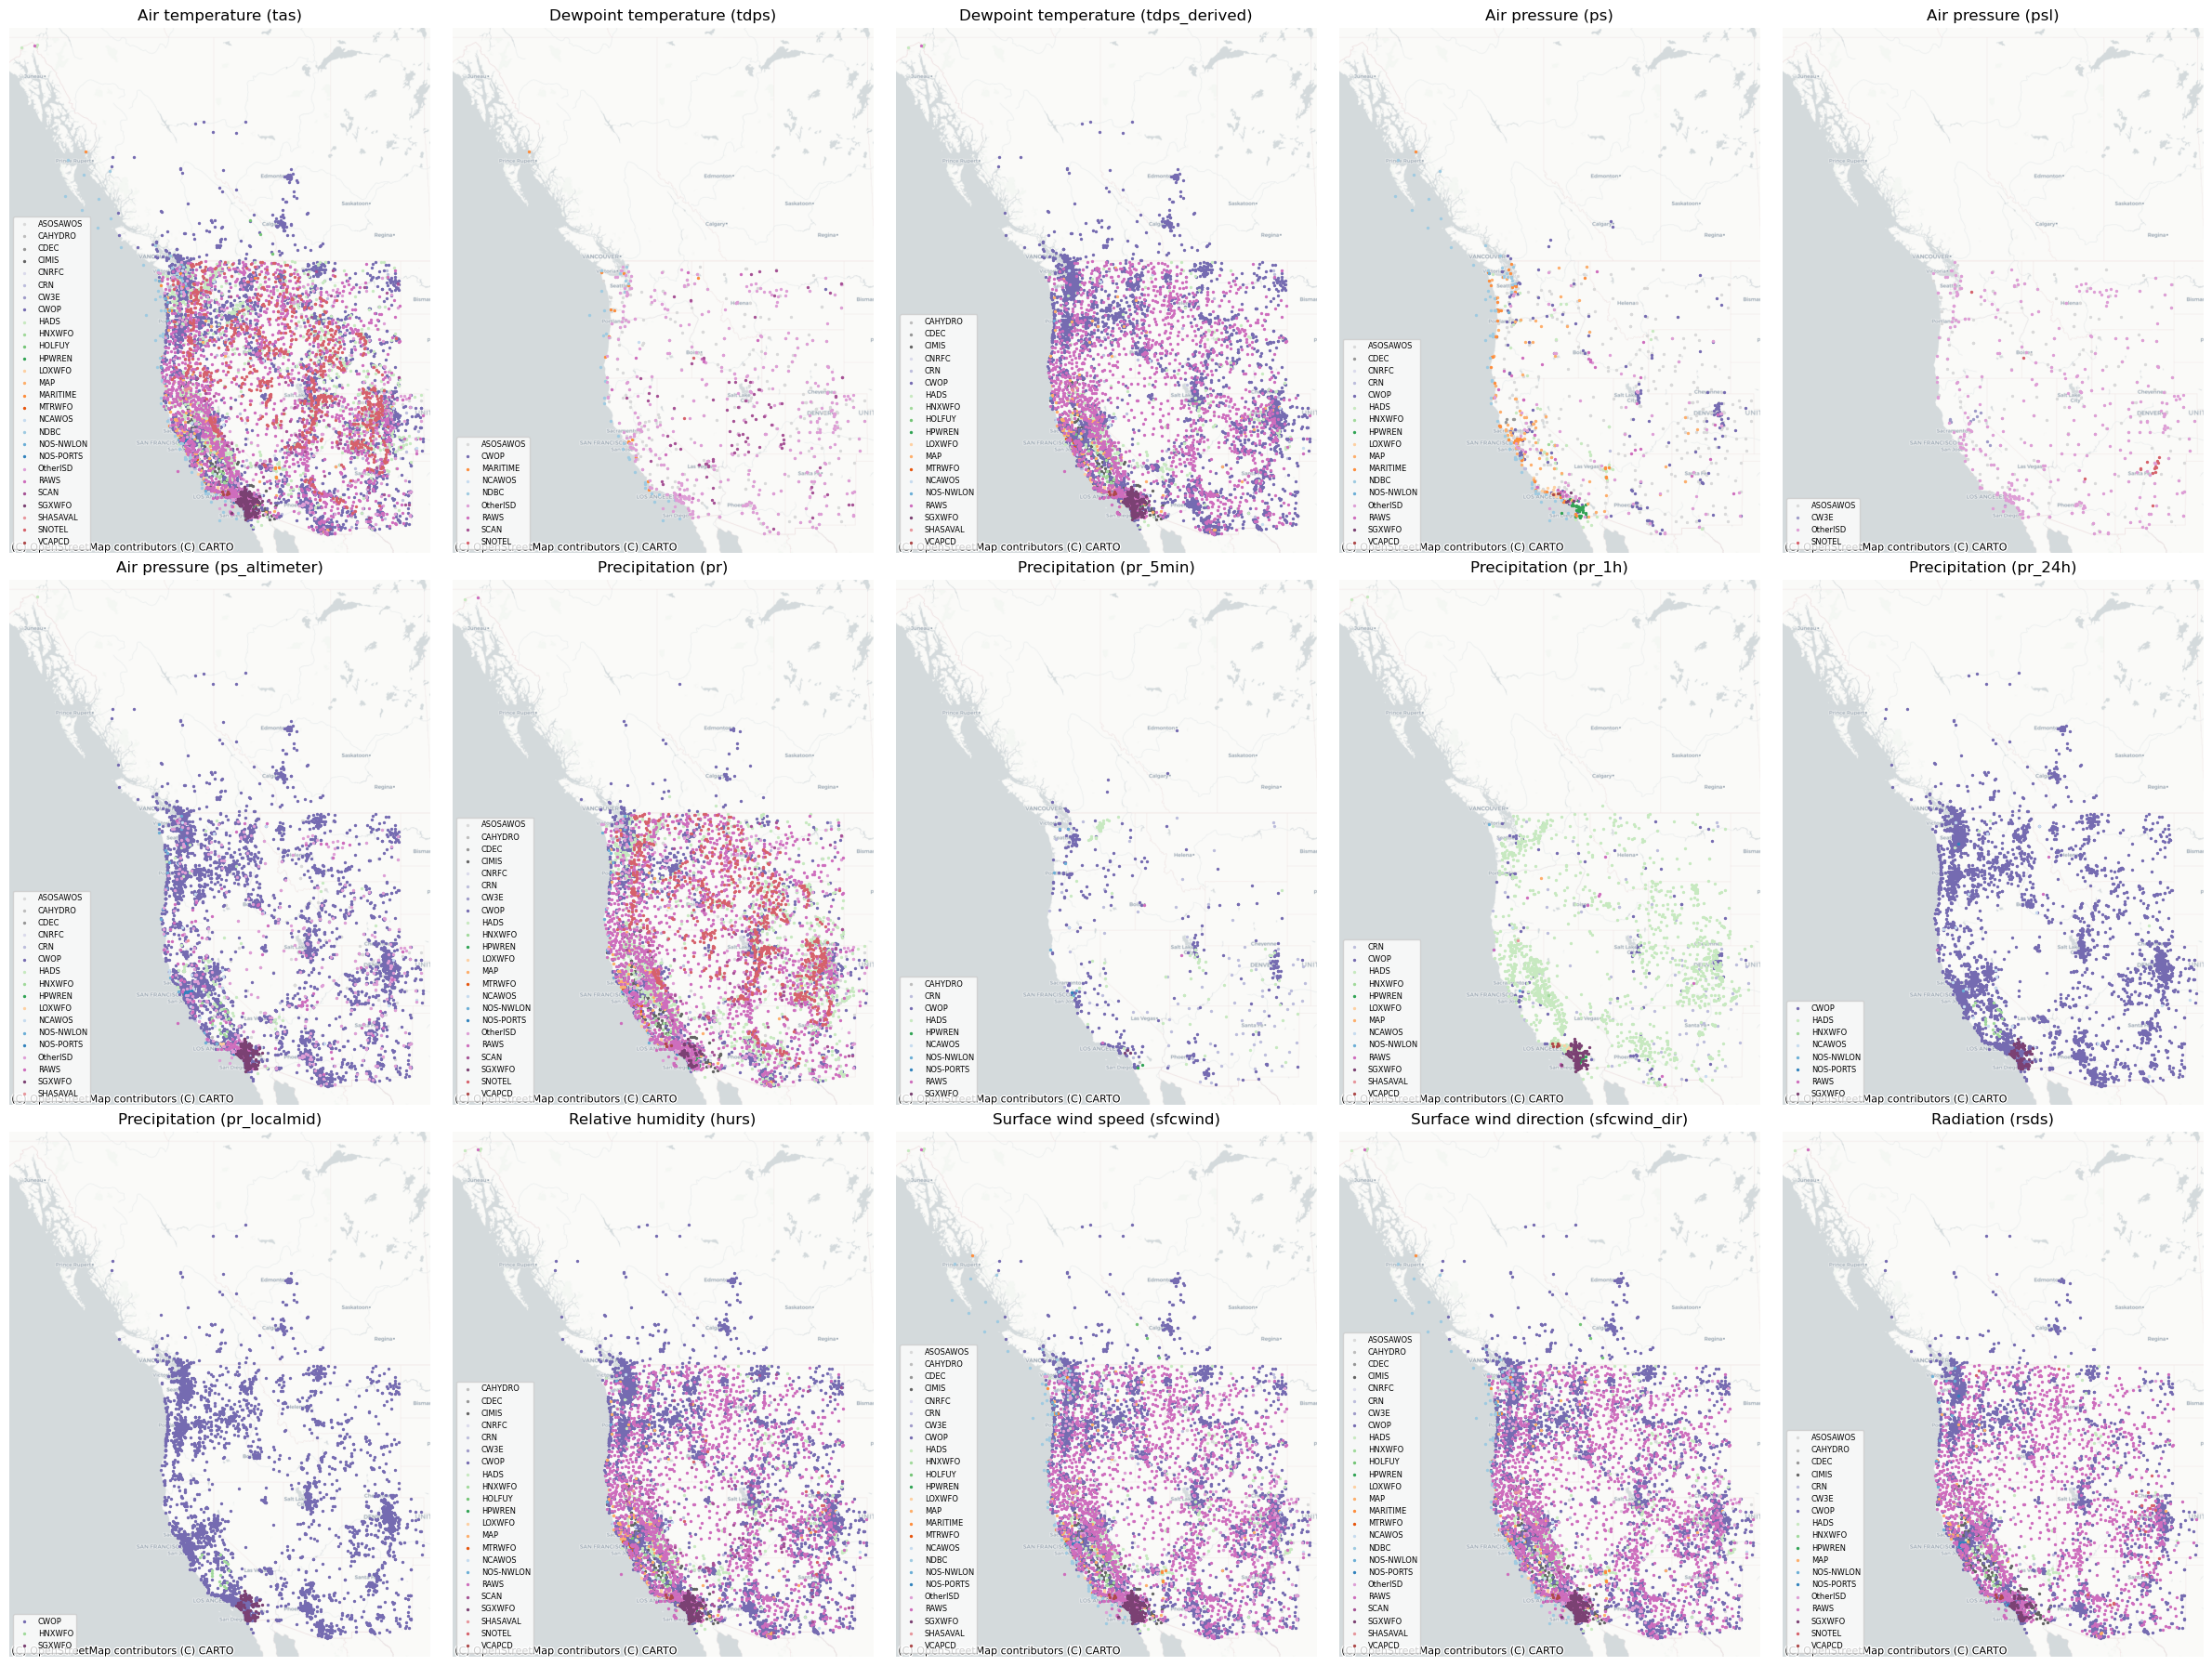

<Figure size 640x480 with 0 Axes>

In [8]:
# 15 vars total
def plot_all_vars(var_list):
    # aws set up    
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    bucket_name = "wecc-historical-wx"
          
    # subplot global settings
    a=1 # alpha
    ms=2 # markersize
    n=1 # initialize plot counter
    
    fig = plt.subplots(nrows=3, ncols=5, figsize=(24,18))
    
    for var_to_plot in var_list:
        ax = plt.subplot(3,5,n)
        
        # enforce WECC boundary, all plots regardless of variable selection
        ylim = [3.5E6, 8.5E6] # lat
        xlim = [-1.53E7, -1.13E7] # lon
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        
        gdf = gdf_setup(var_to_plot)

        # plot by network with correct legend color
        for ctype, data in gdf.groupby('network'):
            color = color_dict[ctype]
            data.plot(color=color,
                      markersize=ms, 
                      alpha=a,
                      ax=ax, 
                      label=ctype, 
                      legend=False)

        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron);

        # set title
        vartitle = var_fullname(var_to_plot)
        ax.set_title(vartitle, fontsize=12)
        ax.set_axis_off()
        
        # legend handling
        l = ax.legend(loc='lower left', prop={'size':6}, frameon=True)
#         for i in range(len(l.legend_handles)):
#             l.legend_handles[i]._sizes = [1] # sets size of points in legend to be more visible
                
        # move ot next subplot
        n = n + 1 
        
    # fix white spacing
    plt.tight_layout()
    
    plt.show()
    
    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0)
    
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_allvars.png")
        
# run function to produce plots
varlist = ['tas','tdps','tdps_derived', 
           'ps','psl','ps_altimeter', 
           'pr','pr_5min','pr_1h','pr_24h','pr_localmid',
           'hurs','sfcwind','sfcwind_dir','rsds']
plot_all_vars(varlist)